- Proyecto: Scoring crediticio
- Dataset: German Credit Data (Kaggle)
- El proyecto cuenta con comentarios que sirven para entender el código y las diferentes fases del proyecto:
1. Definición del problema, objetivo y carga de herramientas y bibliotecas necesarias
2. Preparación y exploración inicial del dataset
3. Limpieza, EDA (análisis exploratorio) y Feature Engineering
4. Preprocesamiento
5. Selección, entrenamiento y optimización del modelo principal
6. Interpretación y evaluación del modelo
7. Conclusiones y otros

1. DEFINICIÓN DE PROBLEMA, OBJETIVO Y CARGA DE HERRAMIENTAS NECESARIAS
- Problema: ¿se puede predecir el riesgo crediticio de un cliente en función de la información disponible?
- Objetivo: desarrollar un modelo de ML de Scoring crediticio completo
- Herramientas necesarias: Pandas/Numpy para manipular datos; Matplotlib para graficar; Scikit-learn para dividir datos, escalar, entrenar un modelo y evaluarlo.

In [1]:
### CARGA DE BIBLIOTECAS Y DATASETS (aunque las iremos cargando a medida que las vayamos necesitando, se aglutinarán en un mismo apartado al inicio del código)
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [2]:
url = "https://raw.githubusercontent.com/tanatosgalan-arch/proyecto_scoring/refs/heads/main/german_credit_data.csv?token=GHSAT0AAAAAADJMFOIILZS2U3KHY3OQMODW2FHFUMA"
df = pd.read_csv(url, delimiter=";")

2. PREPARACIÓN Y EXPLORACIÓN INICIAL DEL DATASET

- Vistazo inicial con size, shape, head(), info(), describe(), value_counts(), isnull()
- Análisis y definición de variables
- Conclusiones iniciales

In [12]:
### 2.1. Vistazo inicial
print(df.size) # Comprobamos que hablamos de un archivo csv en formato tabular con 1000 registros
print(df.shape) # Los 1000 registros están compuestos por 1000 filas y 10 columnas
print(df.head()) # Existe una primera columna llamada Unnamed:0 que identifica al cliente y existen variables con missing values por lo que el archivo requiere de una limpieza
print(df.info()) # Existen 5 variables numéricas y 5 variables categóricas. Dos categóricas cuentan con missing values mientras el resto, a priori, cuentan con todos los valores
print(df.isnull().sum()) # Observamos el número de missing values para cada variable
print(df.describe()) # Para las variables numéricas no hay ninguna std 0 por lo que, a priori, no hay columnas repetidas
print(df.value_counts()) # A priori no parece que haya filas duplicadas

10000
(1000, 10)
   Unnamed: 0  Age     Sex  Job Housing Saving accounts Checking account  \
0           0   67    male    2     own             NaN           little   
1           1   22  female    2     own          little         moderate   
2           2   49    male    1     own          little              NaN   
3           3   45    male    2    free          little           little   
4           4   53    male    2    free          little           little   

   Credit amount  Duration              Purpose  
0           1169         6             radio/TV  
1           5951        48             radio/TV  
2           2096        12            education  
3           7882        42  furniture/equipment  
4           4870        24                  car  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 

In [ ]:
df.rename(columns={"Unnamed: 0": "ID"}, inplace=True) # Renombramos la primera columna de la tabla como ID ya que aparece como Unnamed:0
df.set_index("ID", inplace=True) # Establecemos la recien nombrada columna ID como índice de la tabla
df.loc[df["Duration"]>36] # Hacemos un filtro con clientes con más de 36 meses de duración de crédito y vemos si se han aplicado correctamente nuestros cambios

2.2. Análisis y definición de variables según la información disponible:

- Age (numérica): Edad del cliente
- Sex (categórica: male, female): Sexo del cliente
- Job (numérica: 0 - unskilled and non-resident, 1 - unskilled and resident, 2  skilled, 3 - highly skilled): formación y nacionalidad del cliente
- Housing (categórica: own, rent, or free): tipo de residencia/vivienda habitual del cliente (en propiedad, en alguiler, ni en propiedad ni en alquiler)
- Saving accounts (categórica: little, moderate, quite rich, rich): nivel del cliente en función de su cuenta de ahorros
- Checking account (categórica: ): nivel del cliente en función de su cuenta corriente
- Credit amount (numérica): saldo del crédito del cliente
- Duration (numérica): plazo (en meses) del crédito
- Purpose (categórica: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others): finalidad o racional del crédito

2.3. Conclusiones iniciales:
- La tabla facilitada requiere de una limpieza
- A priori contamos con suficiente información sobre el crédito de los clientes (cantidad, plazo, finalidad) pero no contamos con información cuantitativa relevante sobre los mismos (ingresos, saldos en cuentas, calidad crediticia)
- Teniendo esto en cuenta y sabiendo que no contamos tampoco con algo tan valioso como un historial de pago del cliente, tendremos que basar la calidad crediticia de los clientes en base a información cualitativa (tipo empleo, nivel de ahorros y saldos en c/c y tipo de vivienda habitual).
- A diferencia de otras versiones, en este caso contamos con información limitada sobre los clientes por lo que, a priori, se antoja complicado realizar el ejercicio de la mejor manera, es decir, con una versión que sí tenga la etiqueta de “good / bad” según información histórica.
- La alternativa pasa por crear nosotros mismos una categorización de los clientes en buenos (good) o malos (bad) con una regla de puntuación manual y explicable (score) que se base en las variables que tenemos. Este enfoque es claramente subjetivo, ya que seremos nosotros los que calibraremos los umbrales y daremos un peso relativo a las diferentes variables en base a nuestro criterio, pero es el mejor teniendo en cuenta la información limitada con la que contamos.
- En este caso, lo haremos del siguiente modo. Para hacerlo sencillo, sólo usaremos 3 variables discriminatorias: Housing, Saving accounts y Checking account. Elegimos Housing ya que si un/a cliente es propietario/a de una casa es mucho más improbable que no cobremos nuestro crédito (en caso de impago exigiríamos garantías y/o refinanciar) y Saving accounts/Checking account ya que son las variables que, aun siendo cualitativas, más información nos dan sobre la cap. ahorro y solvencia actual de los clientes (a más ahorros, menor probabilidad de impago de nuestro crédito). Descartamos el resto de variables, para hacerlo más sencillo aunque en la práctica sabemos que tendríamos que considerarlas. Crearemos una columna llamada "risk" que diferenciará entre clientes con buena calidad crediticia (good) o mala (bad) de tal manera que daremos más puntos y marcaremos como "bad" a los más riesgosos.

In [ ]:
def row_score(r): # Definimos como damos puntos a cada cliente
    s = 0 # empezamos con 0 puntos para cada cliente
    # Housing: puntúo de la siguiente manera según mi mejor criterio: own → 0, rent → +1, free → +1
    s += {"own":0, "rent":1, "free":1}.get(str(r["Housing"]).lower(), 0)
    # Saving accounts: puntúo de la siguiente manera según mi mejor criterio: little/no → +2, moderate → +1, quite rich/rich → 0
    s += {"little":2, "no":2, "moderate":1, "quite rich":0, "rich":0}.get(str(r["Saving accounts"]).lower(), 1)
    # Checking account: puntúo de la siguiente manera según mi mejor criterio: little/no → +2, moderate → +1, quite rich/rich → 0
    s += {"little":2, "no":2, "moderate":1, "quite rich":0, "rich":0}.get(str(r["Checking account"]).lower(), 1)
    return s # obtenemos el número total de puntos de cada cliente

df["risk_score"] = df.apply(row_score, axis=1) # lo aplico a todos los clientes y guarda la puntuación en una nueva columna llamada risk_score
# elegimos un umbral (subjetivo) que separa buenos de malos (top 30% como 'bad')
th = df["risk_score"].quantile(0.70) # calculo el 70% percentil o cuantil de las puntuaciones, es decir, ordeno todos los risk_score de menor a mayor y encuentro el número que deja exactamente el 70% por debajo de él.
df["Risk"] = np.where(df["risk_score"] >= th, "bad", "good") # pongo la etiqueta final "bad" or "good" en la nueva columna "Risk"

In [ ]:
df.head()

3. LIMPIEZA, EDA Y FEATURE ENGINEERING
- Completamos los valores nulos o missing values de Saving accounts o Checking account con "unknown" en vez de borrar filas, columnas irrelevantes y registros/filas repetidas
- EDA: Histograma de una variable numérica (Edad), Boxplot de monto de crédito, preparación de variables

Distribución del target (Risk)

df["Risk"].value_counts().plot(kind="bar")
plt.title("Distribución del Riesgo")
plt.show()
👉 Así sabemos cuántos clientes son “good” vs “bad”. Si están desbalanceados (más de un tipo que del otro), es importante para el modelo.

df["Age"].hist(bins=20)
plt.title("Distribución de la Edad")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.show()
👉 Muestra cómo se distribuyen las edades de los clientes.

Boxplot de monto de crédito

df.boxplot(column="Credit amount", by="Risk")
plt.title("Monto de Crédito por Riesgo")
plt.suptitle("")  # quita título automático
plt.show()
👉 Así vemos si los montos de crédito son diferentes entre clientes buenos y malos.

7. Preparar variables para el modelo
Convertimos variables categóricas en numéricas (one-hot encoding).
Definimos X (variables de entrada) y y (objetivo).

df_encoded = pd.get_dummies(df.drop("Risk", axis=1), drop_first=True)

X = df_encoded
y = df["Risk"].map({"good": 0, "bad": 1})  # 0 = good, 1 = bad
👉 get_dummies() crea columnas binarias (0/1) para las categorías.👉 map() convierte “good/bad” en números (necesarios para ML).



In [ ]:
# Completamos los missing values
df["Saving accounts"] = df["Saving accounts"].fillna("unknown")
df["Checking account"] = df["Checking account"].fillna("unknown")

In [ ]:
df.head()

In [ ]:
### Distribución del target (Risk):
df["Risk"].value_counts().plot(kind="bar")
plt.title("Distribución del Riesgo")
plt.show()

In [ ]:
### Histograma de una variable numérica (Edad) para ver cómo se distribuyen los clientes por edad
df["Age"].hist(bins=20)
plt.title("Distribución de la Edad")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.show()

In [ ]:
### Boxplot de monto de crédito para ver si son diferentes entre clientes buenos y malos
df.boxplot(column="Credit amount", by="Risk")
plt.title("Monto de Crédito por Riesgo")
plt.suptitle("")  # quitamos el título que aparece por defecto
plt.show()

4. PREPROCESAMIENTO
- Preparamos variables para el modelo convirtiendo las variables categóricas en numéricas (one-hot encoding) y definimos y (variable objetivo o target) y X (variables de entrada o features).
- Dividimos los datos (train_test_split)
- Escalamos ya que hay variables como edad o monto que tienen escalas muy diferentes que podrían sesgar el modelo


In [ ]:
### Convertimos variables categóricas en numéricas y definimos las features (variables predictoras) y la target (variable objetivo)

df_encoded = pd.get_dummies(df.drop("Risk", axis=1), drop_first=True) # Creamos columnas binarias para las categorías

X = df_encoded
y = df["Risk"].map({"good": 0, "bad": 1})  # con map() convertimos “good/bad” en números (necesarios para ML): 0 = good, 1 = bad

In [ ]:
### Dividimos los datos teniendo en cuenta que la variable target está desbalanceada

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Hacemos nuestra división (80% entrenamiento, 20% prueba) y usamos stratify para mantener la proporción de clases.

In [ ]:
### Escalamos para evitar construir un modelo sesgado.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Antes de entrenar regresión logística es bueno estandarizar o normalizar las variables. Podríamos tb. haber hecho un Pipeline = escalado + regresión logística
#pipe = Pipeline([
#    ("scaler", StandardScaler()),
#    ("logreg", LogisticRegression(max_iter=1000))
#])

5. SELECCIÓN, ENTRENAMIENTO Y OPTIMIZACIÓN DEL MODELO
- Usaremos un modelo de predicción simple: Regresión Logística
- Lo entrenaremos con los datos de entrenamiento (train)


In [ ]:
### Usamos el modelo sencillo de Regresión Logística y entrenamos el modelo
model_1 = LogisticRegression(max_iter=1000)
model_1.fit(X_train_scaled, y_train)

6. INTERPRETACIÓN Y EVALUACIÓN DEL MODELO
- Lo haremos mediante un reporte de clasificación y una tabla de confusión


In [ ]:
### Evaluamos el modelo
y_pred = model_1.predict(X_test_scaled)

In [ ]:
### Obtenemos métricas de desempeño con un reporte de clasificación y una matriz de confusión
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

7. Conclusiones (sobre los resultados observados) y otros
- El modelo clasificó perfectamente todos los ejemplos de prueba.
- Según la matriz de confusión, no hay falsos positivos ni falsos negativos → predicción impecable en este conjunto de datos.
- Podemos hacer dos lecturas, (i) que el modelo es muy bueno para este problema ó (2) que existe un posible riesgo de sobreajuste (overfitting) si el dataset de prueba no es suficientemente representativo o si el modelo memorizó los datos.
- En este caso recomendaríamos:
(1) Hacer una validación cruzada para confirmar que el rendimiento se mantiene en diferentes particiones.
(2) Usar otros modelos

In [ ]:
### Hacemos un ejercicio de validación cruzada para comprobar si el modelo realmente generaliza o si solo memoriza datos
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Usamos StratifiedKFold para que en cada división haya la misma proporción de clases (e.g. 5 particiones - 5-fold cross-validation)

In [ ]:
### Evaluamos de nuevo el modelo
scores = cross_val_score(model_1, X, y, cv=cv, scoring="accuracy")

In [ ]:
### Obtenemos resultados y desempeño
print("Accuracies por fold:", scores)
print("Accuracy promedio:", np.mean(scores))
print("Desviación estándar:", np.std(scores))

- Según las métricas, el modelo es muy robusto.
- El promedio nos da una mejor estimación de cómo rendirá en datos nuevos.

In [ ]:
### A pesar de los resultados obtenidos, probamos a usar otros algoritmos o modelos: RandomForestClassifier y XGBoostClassifier

model_2 = RandomForestClassifier(random_state=42) # Definimos como algoritmo o modelo 2 (model_2) a RandomForestClassifier para diferenciarlo del modelo 1 (model_1) que era LogisticRegression
model_2.fit(X_train, y_train) # Entrenamos el modelo
y_pred_model_2 = model_2.predict(X_test) # Evaluamos el desempeño

print("Accuracy:", accuracy_score(y_test, y_pred_model_2)) # Obtenemos métricas de desempeño
print(confusion_matrix(y_test, y_pred_model_2))
print(classification_report(y_test, y_pred_model_2))

In [ ]:
### Interpretamos los resultados ahora con SHAP
explainer = shap.TreeExplainer(model_2)
shap_values = explainer.shap_values(X_test)

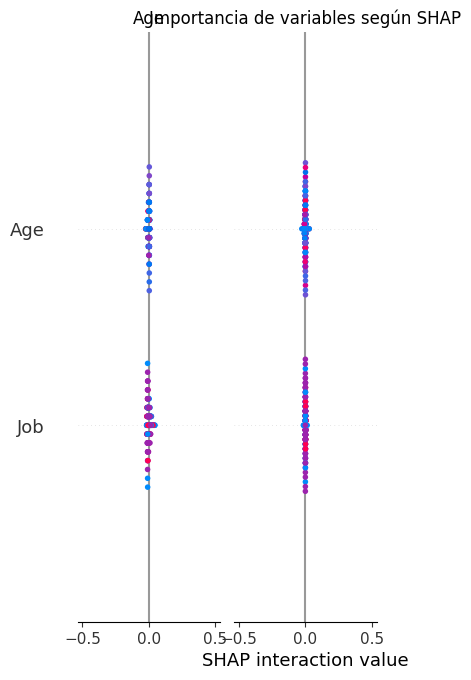

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False) # Medimos la importancia promedio de las variables (qué variables pesan más en nuestro modelo)
plt.title("Importancia de variables según SHAP")
plt.show()

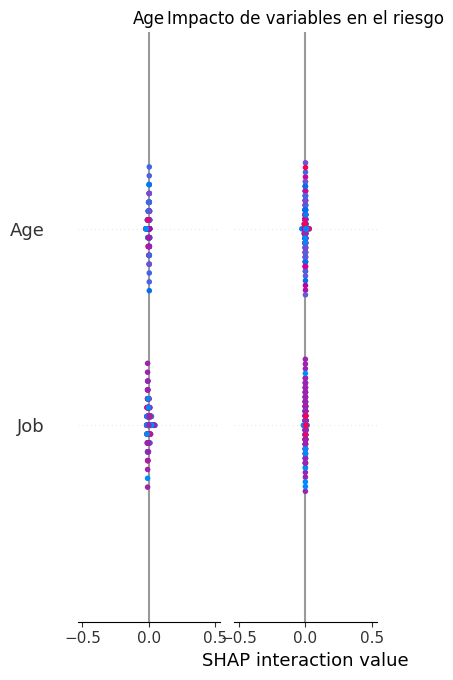

In [ ]:
shap.summary_plot(shap_values, X_test, show=False) # Cómo influyen las variables en la predicción
plt.title("Impacto de variables en el riesgo")
plt.show()

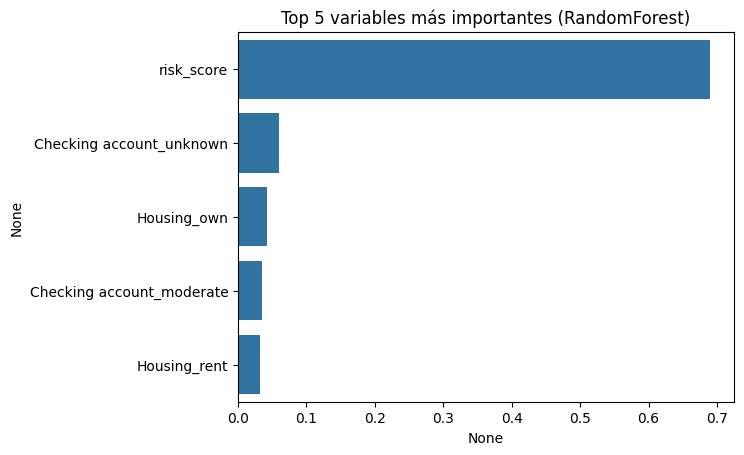

In [ ]:
importances = pd.Series(model_2.feature_importances_, index=X.columns).sort_values(ascending=False) # Importancia clásica de RandomForest

sns.barplot(x=importances.head(5), y=importances.head(5).index)
plt.title("Top 5 variables más importantes (RandomForest)")
plt.show()

In [ ]:
SHAP barplot → muestra qué variables pesan más en el modelo.
Ejemplo: si Credit amount aparece arriba, significa que el monto del crédito es muy influyente.
SHAP summary (scatter) → muestra cómo valores altos o bajos de cada variable empujan hacia "good" o "bad".
Ejemplo: edad muy baja podría estar más asociada a “bad risk”.
Feature importance (RandomForest) → otro gráfico sencillo para confirmar las 5 variables principales.
📌 Ejemplo de conclusión interpretativa (estilo amateur)
Después de entrenar mi modelo con RandomForest y analizarlo con SHAP, vi que las variables más importantes son Credit amount, Duration, Age, Saving accounts y Checking account. Esto quiere decir que el monto del crédito y cuánto dura el préstamo pesan mucho para que el modelo decida si alguien es "good" o "bad".
Los gráficos de SHAP muestran que cuando el monto del crédito es alto y la duración es larga, el riesgo de ser “bad” aumenta. También se ve que tener pocas cuentas de ahorro o chequeo suma riesgo.

En resumen, aunque soy nuevo en esto, puedo decir que el modelo encuentra que la capacidad de ahorro y el monto del crédito son claves para diferenciar buenos de malos clientes.

👉 Con esto ya tienes: top 5 variables, gráficos explicativos y una conclusión sencilla.
¿Quieres que te arme el mismo análisis también para XGBoost (con SHAP se puede igual) para que compares cómo cambia la importancia de variables según el modelo?

In [ ]:
model_3 = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42) # Definimos como algoritmo o modelo 3 (model_2) a XGBoostClassifier para diferenciarlo de los otros dos
model_3.fit(X_train, y_train) # Entrenamos el modelo
y_pred_model_3 = model_3.predict(X_test) # Evaluamos el modelo

print("Accuracy:", accuracy_score(y_test, y_pred_model_3)) # Obtenemos métricas de desempeño
print(confusion_matrix(y_test, y_pred_model_3))
print(classification_report(y_test, y_pred_model_3))

Accuracy: 1.0
[[139   0]
 [  0  61]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       139
           1       1.00      1.00      1.00        61

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:18:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
